# Fetching observations from MET data base services

This notebook serves as sandbox for fetching data from frost.met, havvarsel-frost.met and thredds.met

See https://api.met.no/ for all interfaces and possible sources!!


## Havvarsel frost
Havvarsel frost delivers so far `temperature` measurements originated from badevann.no at seven beaches in the south of Norway (glider data integrated in the meantime, but not yet used here!). 
> Documentation:
> - API documentation for obs/badevann https://havvarsel-frost.met.no/docs/apiref#/obs%2Fbadevann/obsBadevannGet 
> - Datastructure described on https://havvarsel-frost.met.no/docs/dataset_badevann




In [1]:
# Importing general libraries
import sys
import json
import datetime
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import netCDF4
import pyproj

### Example to fetch time series

In [2]:
start_time = datetime.datetime.strptime("2010-10-01T00:00", "%Y-%m-%dT%H:%M")
end_time = datetime.datetime.strptime(datetime.datetime.now().isoformat(timespec='minutes'), "%Y-%m-%dT%H:%M")


In [3]:
frost_api_base="https://havvarsel-frost.met.no"
endpoint = frost_api_base + "/api/v1/obs/badevann/get"

payload = {'time': str(start_time.isoformat()) + "Z/" + str(end_time.isoformat()) + "Z", 
                    'incobs':'true', 'buoyids': "003", 'parameter':'temperature'}
# the havvarsel-frost API uses colon in the url and does not replace them with ASCI what is default
payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())

In [4]:
try:
    r = requests.get(endpoint, params=payload_str)
    print("Trying " + r.url)
    r.raise_for_status()
except requests.exceptions.HTTPError as err:
    raise Exception(err)


Trying https://havvarsel-frost.met.no/api/v1/obs/badevann/get?time=2010-10-01T00:00:00Z/2022-06-14T13:51:00Z&incobs=true&buoyids=003&parameter=temperature


In [5]:
r.json()["data"]["tseries"][0]["observations"][-1]["time"]

'2020-09-15T07:03:00Z'

### Explore available data

Note that the availability of data depends on the selected dates!

In [6]:
badevann_df = pd.DataFrame(columns=['buoyid', 'name', 'lat', 'lon', 'source', 'N_obs', 'first_obs', 'last_obs'])

frost_api_base="https://havvarsel-frost.met.no"
endpoint = frost_api_base + "/api/v1/obs/badevann/get"

r = requests.get(endpoint)
print("Trying " + r.url)
r.raise_for_status()

badevann_df = pd.DataFrame(columns=['buoyid', 'name', 'lat', 'lon'])
for i in range(len(r.json()["data"]["tseries"])):
    buoyid = r.json()["data"]["tseries"][i]["header"]["id"]["buoyid"]
    source = r.json()["data"]["tseries"][i]["header"]["id"]["source"]
    name = r.json()["data"]["tseries"][i]["header"]["extra"]["name"]
    lat = r.json()["data"]["tseries"][i]["header"]["extra"]["pos"]["lat"]
    lon = r.json()["data"]["tseries"][i]["header"]["extra"]["pos"]["lon"]

    payload = {'time': str(start_time.isoformat()) + "Z/" + str(end_time.isoformat()) + "Z", 
                    'incobs':'true', 'buoyids': buoyid, 'parameter':'temperature'}
    payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())
    try:
        r_ts = requests.get(endpoint, params=payload_str)
        N_obs = len(r_ts.json()["data"]["tseries"][0]["observations"])
        first_obs = r_ts.json()["data"]["tseries"][0]["observations"][0]["time"][0:10]
        last_obs = r_ts.json()["data"]["tseries"][0]["observations"][-1]["time"][0:10]
    except:
        N_obs = 0
    if N_obs >= 100:
        badevann_df = badevann_df.append({"buoyid" : buoyid, "name" : name, "lat" : float(lat), 
            "lon" : float(lon), "source" : source, "N_obs" : int(N_obs), 
            "first_obs": first_obs, "last_obs":last_obs}, ignore_index=True)

badevann_df = badevann_df.astype({"N_obs":int})

Trying https://havvarsel-frost.met.no/api/v1/obs/badevann/get


In [7]:
badevann_df

,buoyid,name,lat,lon,N_obs,first_obs,last_obs,source
0,53,Brønnstadbukta,59.078139,9.717251,14514,2019-07-10,2021-09-29,badetassen.no
1,1-277221,Skrova,68.165330,14.688650,110,2020-10-27,2022-06-14,yr.no
2,51,Kråkeskarvet,60.473128,7.075648,13559,2019-07-08,2021-11-08,badetassen.no
3,23,Kanalparken,58.769550,5.848330,15029,2019-06-20,2022-06-14,badetassen.no
4,119,Øvstabøstølen,58.865634,6.568206,14528,2020-09-28,2021-11-27,badetassen.no
...,...,...,...,...,...,...,...,...
159,61,Myklebust Sjøbad,58.947280,5.570110,15226,2019-08-22,2022-06-14,badetassen.no
160,107,Kyvannet,63.404594,10.342120,2011,2020-07-06,2021-10-04,badetassen.no
161,86,Gakorivannet,69.941330,23.209550,11079,2020-06-11,2022-06-14,badetassen.no
162,118,Telegrafbukta,69.631570,18.905230,1684,2021-08-22,2022-01-11,badetassen.no


In [8]:
badevann_df.to_csv("badevann-buoys.csv", sep=",", index=False)

See the output file for information about all buoys!

The following script adds more meta information from other sources

In [32]:
def add_more_meta_data(filename):
    """ 
    Adding information about the simulated depth from NorKyst to the existing file containing information from havvarsel-frost
    """
    import NorKystImporter    
    buoy_df = pd.read_csv(filename) 
    buoy_df["norkyst_depth"] = ""

    for i in range(len(buoy_df)):
        buoy_df.at[i,"norkyst_depth"] = NorKystImporter.NorKystImporter.simulated_depth(buoy_df.at[i,"lat"], buoy_df.at[i,"lon"])

    buoy_df.to_csv(filename, sep=",", index=False)

add_more_meta_data("badevann-buoys.csv")

### Explore professional buoys in map

(Not yr.no-manual observations)

In [9]:
badevann_df = badevann_df[badevann_df["source"]!="yr.no"]

In [10]:
N = badevann_df.shape[0]
lon = np.array(badevann_df["lon"],dtype=float)
lat = np.array(badevann_df["lat"],dtype=float)
buoyid = np.array(badevann_df["buoyid"],dtype=str)


In [11]:
nc = netCDF4.MFDataset(['https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2021100100.nc']) #an example file 

proj = pyproj.Proj(nc["projection_stere"].proj4)

lons = nc["lon"][:].data
lats = nc["lat"][:].data

In [12]:
def latlon2cell(lat_mesh, lon_mesh, lat, lon):
    distances = (lat_mesh-lat)**2 + (lon_mesh-lon)**2 
    return np.unravel_index(distances.argmin(), distances.shape)

def latlonPROJcell(proj, lat, lon):
    x, y = proj(lon,lat,inverse=False)
    x = x/800
    y = y/800
    return x, y

In [13]:
xys = np.zeros((lon.shape[0],2))
for buoy in range(lon.shape[0]): 
    xys[buoy,0], xys[buoy,1] = latlonPROJcell(proj, lat[buoy], lon[buoy])

In [14]:
h = nc["h"][:].data
land_value = h.min()
land = np.ma.masked_where(h == land_value, h)

In [15]:
def plot_sites(land, xys, buoyid, subarea=None):
    "subarea = [x0 x1 y0 y1]"    
    if subarea is None:
        subarea = [0, land.shape[1], 0, land.shape[0]]
    buoy_subarea = np.logical_and(np.all(xys < [subarea[1],subarea[3]], axis=1), np.all(xys > [subarea[0],subarea[2]], axis=1))

    fig, ax = plt.subplots(1,1,figsize=(40,15))
    ax.imshow(land[subarea[2]:subarea[3],subarea[0]:subarea[1]], cmap='ocean', origin="lower")
    ax.scatter(xys[buoy_subarea,0]-subarea[0], xys[buoy_subarea,1]-subarea[2], c='r', marker='x')
    for i, txt in enumerate(buoyid[buoy_subarea]):
        ax.annotate(str(txt), (xys[np.arange(N)[buoy_subarea][i],0]-subarea[0], xys[np.arange(N)[buoy_subarea][i],1]-subarea[2]))

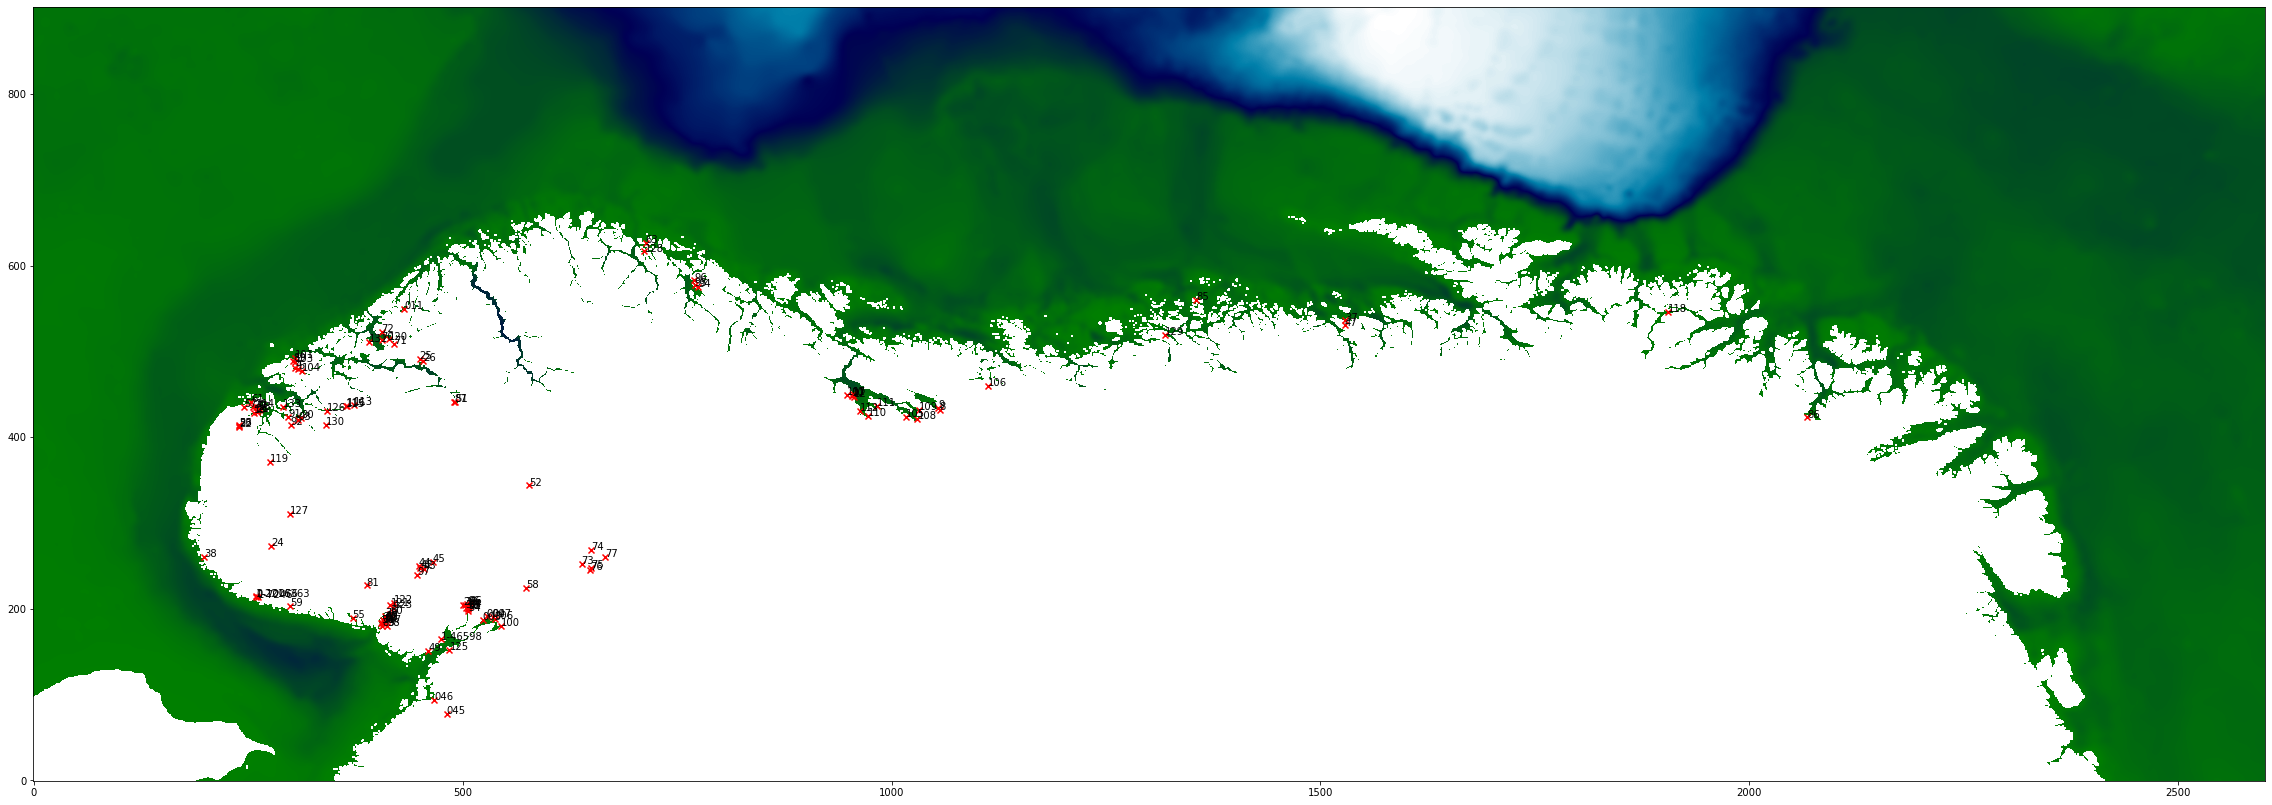

In [16]:
plot_sites(land, xys, buoyid)

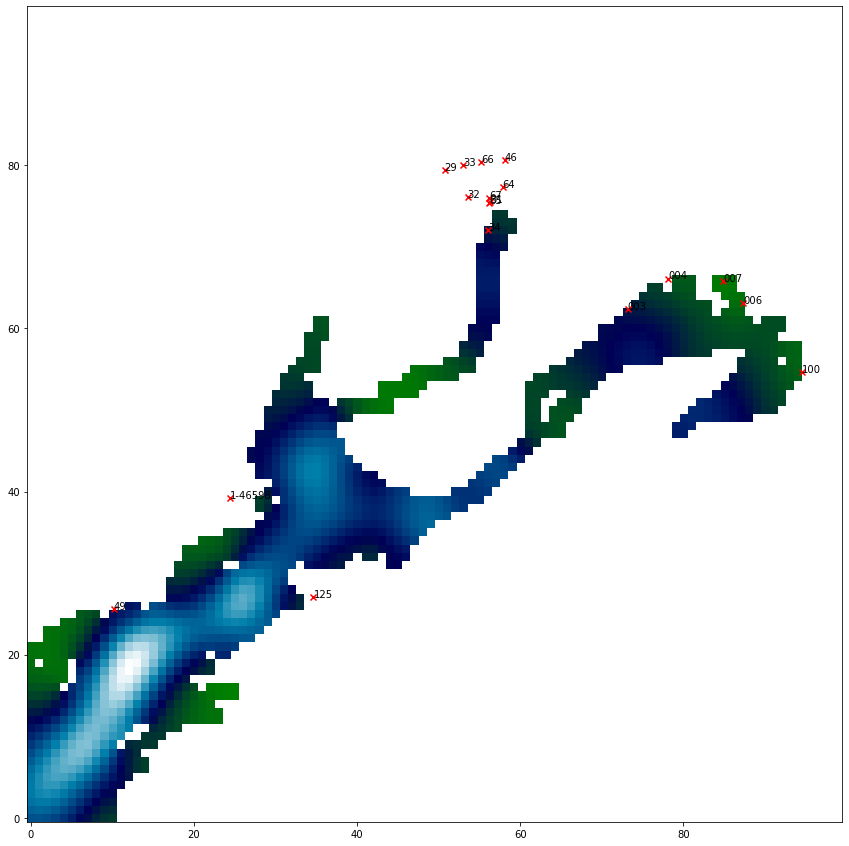

In [17]:
plot_sites(land, xys, buoyid, subarea=[450,550,125,225])